# Skapa 2 modeller per ticker   
1. En modell som använder tomorrows close som target  
2. En modell som använder day after tomorrows close som target   
3. Jämför CatBoost med XGBoost GridSearchCV med cross validation för tidsserier

In [1]:
import sklearn

import xgboost as xgb

import catboost
from catboost import CatBoostClassifier

# from pytrends.request import TrendReq
# import pytrends
import sys
import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
import ta
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score    
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# plt.style.use('fivethirtyeight')
pd.set_option('display.width', 200)
import plotly.express as px
import streamlit as st
# import google

from IPython.display import display
# set display witdh to 200
pd.set_option('display.width', 200)
# set display height to 500
pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = 200    # default 20
pd.options.display.max_colwidth = 60  # default 50
# pd.options.display.precision = 4      # default 6
import logging

# Starta upp logging och inkluder rad nummer
logging.basicConfig(level=logging.INFO, filemode='w', filename='krypto.log', force=True,
                    encoding='utf-8', format= '%(asctime)s - %(levelname)s - %(lineno)d - %(message)s')
logging.info('Startar')


In [2]:
print('Versioner av softvara som används i denna notebook:')
# print numpy version
print('numpy=={}'.format(np.__version__))
# print pandas version
print('pandas=={}'.format(pd.__version__))
# print matplotlib version
print('matplotlib=={}'.format(plt.matplotlib.__version__)) # type: ignore
# print yfinance version
print('yfinance=={}'.format(yf.__version__))
# print pytreands version
print('pytrends==4.8.0') 
# print python-dateutil version
print('python-dateutil==2.8.2')
# print ta version
print('ta==0.10.2')
# print streamlit version
print('streamlit=={}'.format(st.__version__))
print('xgboost=={}'.format(xgb.__version__))
print('catboost=={}'.format(catboost.__version__))

print('sklearn=={}'.format(sklearn.__version__))
#print google version
print('google-crc32==1.1.2')
# print pandas-ta version
print('pandas-ta==0.3.14b0')
# print plotly version
print('plotly==5.3.1')



Versioner av softvara som används i denna notebook:
numpy==1.23.5
pandas==1.4.4
matplotlib==3.7.0
yfinance==0.2.12
pytrends==4.8.0
python-dateutil==2.8.2
ta==0.10.2
streamlit==1.14.0
xgboost==1.7.1
catboost==1.1.1
sklearn==1.0.2
google-crc32==1.1.2
pandas-ta==0.3.14b0
plotly==5.3.1


# Här följer ChatGPT inspirerad kod för att skapa data från yahoo finance

In [3]:
tickers = ['BTC-USD','ETH-USD','BCH-USD','ZRX-USD','XRP-USD']
ticker_names = ['Bitcoin','Ethereum','Bitcoin Cash','0X','Ripple']

In [4]:
def import_ticker_data(tickers, ticker_names):
    df = yf.download(tickers, interval='1d',
                       group_by='ticker', auto_adjust=True)
    df = pd.DataFrame(df.xs('Close', level=1, axis=1))
    df.columns = ticker_names
    df.dropna(inplace=True)
    
    df = df.assign(**{ticker_name + '_pct_change': df[ticker_name].pct_change()*100 for ticker_name in ticker_names})
    df.fillna(0, inplace=True)
    # df.dropna(inplace=True)
    
    return df

df = import_ticker_data(tickers, ticker_names)
df.tail(10)

[*********************100%***********************]  5 of 5 completed


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_pct_change,Ethereum_pct_change,Bitcoin Cash_pct_change,0X_pct_change,Ripple_pct_change
Date,,,,,,,,,,
2023-03-19,1785.576538,136.125992,0.249997,0.388465,28038.675781,1.357633,3.668014,7.814955,3.747527,3.978349
2023-03-20,1735.321289,130.603912,0.234314,0.374628,27767.236328,-2.814511,-4.056594,-6.273279,-3.561963,-0.968089
2023-03-21,1806.760742,134.461746,0.238597,0.469710,28175.816406,4.116785,2.953842,1.827894,25.380373,1.471447
2023-03-22,1737.717041,126.236031,0.227455,0.422480,27307.437500,-3.821408,-6.117514,-4.669799,-10.055142,-3.082001
2023-03-23,1816.405151,128.812714,0.237676,0.444850,28333.972656,4.528246,2.041163,4.493631,5.294928,3.759178
2023-03-24,1752.044800,123.892990,0.229557,0.425902,27493.285156,-3.543282,-3.819284,-3.415996,-4.259411,-2.967065
2023-03-25,1743.764771,125.152679,0.224970,0.444716,27494.707031,-0.472592,1.016756,-1.998194,4.417447,0.005172
2023-03-26,1775.676758,124.873459,0.229373,0.448817,27994.330078,1.830063,-0.223104,1.957148,0.922163,1.817161
2023-03-27,1715.460815,120.268066,0.215715,0.479991,27139.888672,-3.391155,-3.688047,-5.954488,6.945809,-3.052195


In [5]:
def beräkna_rolling_mean(df, ticker_names, window=20):
    rolling_mean=pd.DataFrame()
    for ticker_name in ticker_names:
        df[ticker_name+'-rolling']= df[ticker_name].rolling(window=window).mean()
        
    df.dropna(inplace=True)    
    return df   

def beräkna_cumulative_return(df, ticker_names):
    cumulative_return={}
    for ticker_name in ticker_names:
        cumulative_return[ticker_name] = (df[ticker_name].iloc[-1]/df[ticker_name].iloc[0]-1)
    return cumulative_return

df = beräkna_rolling_mean(df, ticker_names, window=20)
display(df.head())
display(pd.DataFrame(beräkna_cumulative_return(df.query("Date > '2021-04-13'"), ticker_names), index=['cum_ret']).head())


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_pct_change,Ethereum_pct_change,Bitcoin Cash_pct_change,0X_pct_change,Ripple_pct_change,Bitcoin-rolling,Ethereum-rolling,Bitcoin Cash-rolling,0X-rolling,Ripple-rolling
Date,,,,,,,,,,,,,,,
2017-11-28,472.902008,1546.180054,0.225542,0.299152,10058.799805,-1.551561,-4.707957,-3.249444,17.810235,2.448988,373.973451,1313.403958,0.208566,0.231176,7840.200977
2017-11-29,427.523010,1359.709961,0.190781,0.243064,9888.610352,-9.595856,-12.060050,-15.412206,-18.748993,-1.691946,379.305402,1348.674307,0.206577,0.232455,7977.452490
2017-11-30,447.114014,1389.780029,0.188614,0.250878,10233.599609,4.582444,2.211506,-1.135858,3.214793,3.488754,386.698453,1367.792310,0.206147,0.234674,8158.225464
2017-12-01,466.540009,1462.680054,0.201924,0.255699,10975.599609,4.344752,5.245436,7.056741,1.921652,7.250626,394.291403,1373.903815,0.206385,0.236938,8389.125439
2017-12-02,463.449005,1434.979980,0.211218,0.255492,11074.599609,-0.662538,-1.893789,4.602724,-0.080957,0.902001,402.068454,1376.209814,0.207551,0.239846,8645.351929


,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple
cum_ret,-0.287602,-0.853341,-0.899817,-0.728818,-0.573477


In [6]:
pct_list=['Bitcoin_pct_change',	'Ethereum_pct_change',	'Bitcoin Cash_pct_change',	'0X_pct_change',	'Ripple_pct_change'	]
df.head()

,Bitcoin,Ethereum,Bitcoin Cash,0X,Ripple,Bitcoin_pct_change,Ethereum_pct_change,Bitcoin Cash_pct_change,0X_pct_change,Ripple_pct_change,Bitcoin-rolling,Ethereum-rolling,Bitcoin Cash-rolling,0X-rolling,Ripple-rolling
Date,,,,,,,,,,,,,,,
2017-11-28,472.902008,1546.180054,0.225542,0.299152,10058.799805,-1.551561,-4.707957,-3.249444,17.810235,2.448988,373.973451,1313.403958,0.208566,0.231176,7840.200977
2017-11-29,427.523010,1359.709961,0.190781,0.243064,9888.610352,-9.595856,-12.060050,-15.412206,-18.748993,-1.691946,379.305402,1348.674307,0.206577,0.232455,7977.452490
2017-11-30,447.114014,1389.780029,0.188614,0.250878,10233.599609,4.582444,2.211506,-1.135858,3.214793,3.488754,386.698453,1367.792310,0.206147,0.234674,8158.225464
2017-12-01,466.540009,1462.680054,0.201924,0.255699,10975.599609,4.344752,5.245436,7.056741,1.921652,7.250626,394.291403,1373.903815,0.206385,0.236938,8389.125439
2017-12-02,463.449005,1434.979980,0.211218,0.255492,11074.599609,-0.662538,-1.893789,4.602724,-0.080957,0.902001,402.068454,1376.209814,0.207551,0.239846,8645.351929


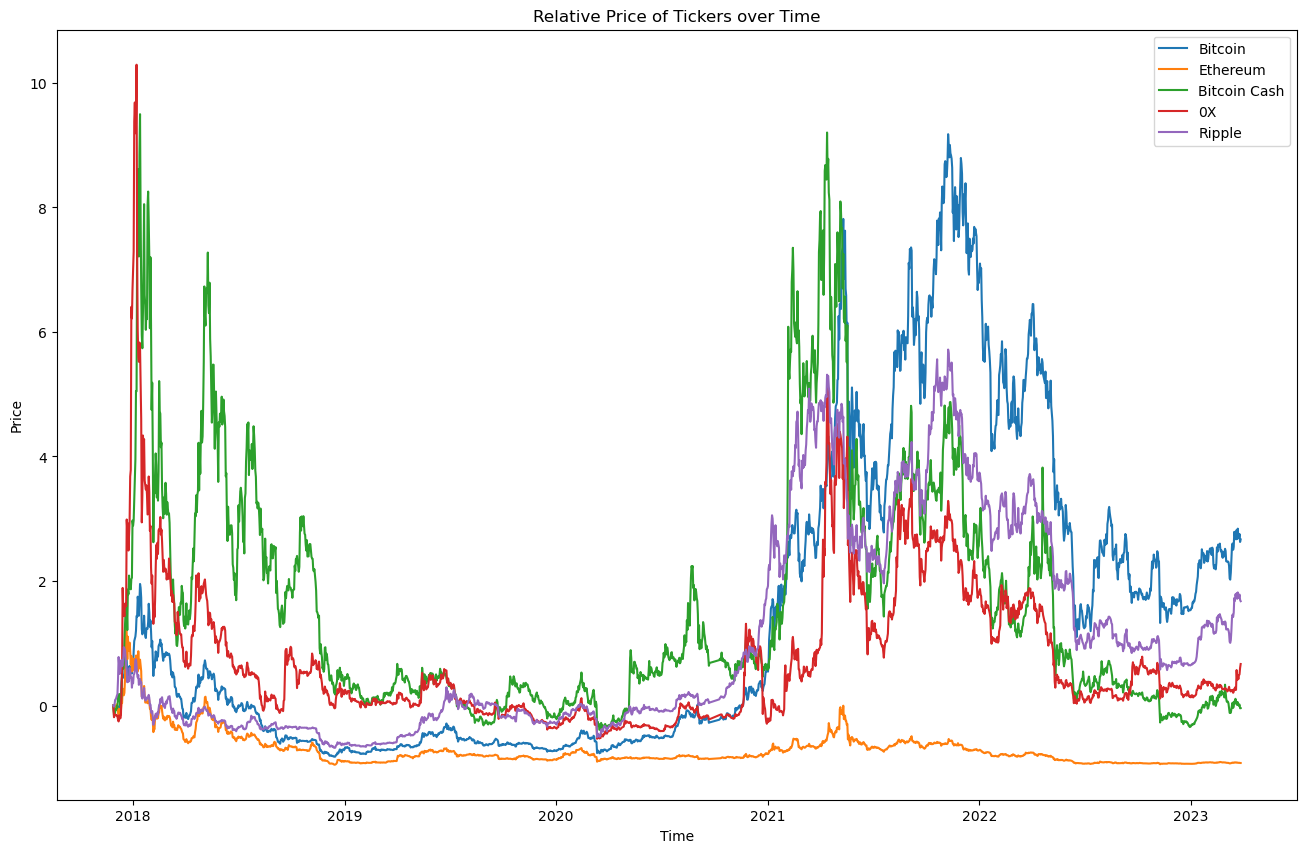

In [7]:
def plot_ticker_data(df, tickers, start=None):
    plt.figure(figsize=(16, 10))
    # df = df.query('index > "2021-04-13"')
    if start is not None:
        df = df.query('index > @start') 
    for ticker in tickers:
        
        data = df[ticker] / df[ticker][0] - 1
        plt.plot(data, label=ticker)
    
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.title('Relative Price of Tickers over Time')
    plt.show()
plot_ticker_data(df, ticker_names)

# Slut på chatGPT




## Get inflation data US and SE

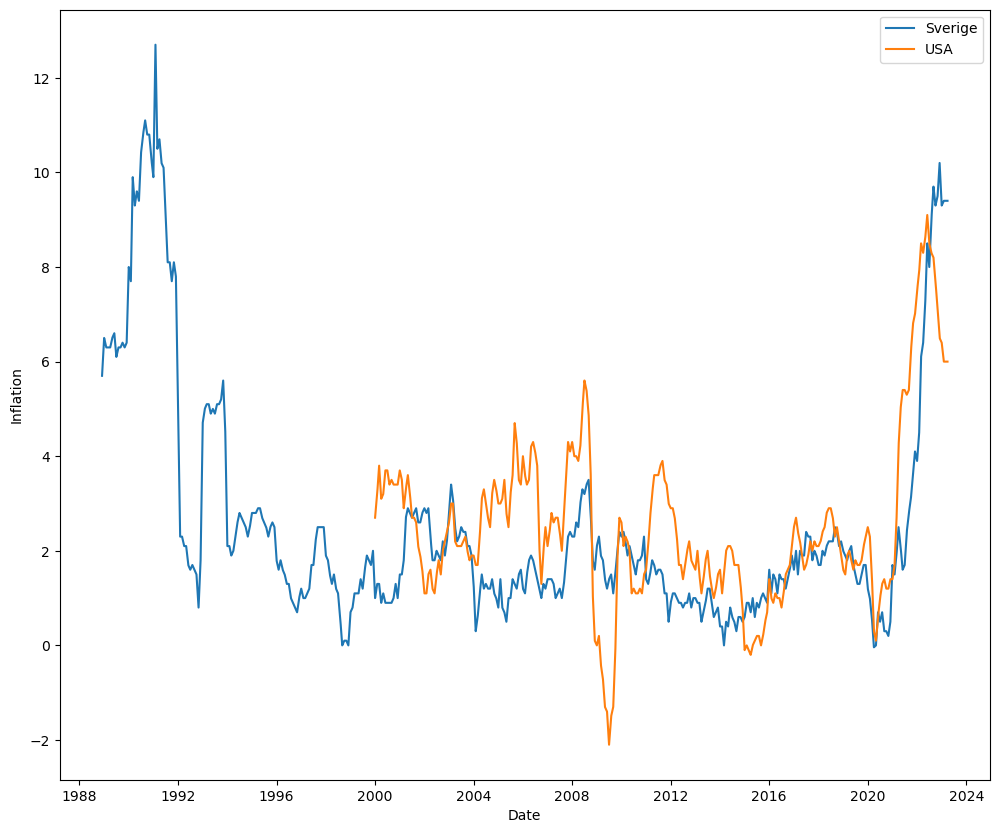

In [8]:
def add_horizon_columns(inflation, horizons):
    # print(horizons)
    for horizon in  horizons:
        # print(horizon)
        inflation['US_inflation_'+str(horizon)] = inflation['US_inflation'].rolling(horizon, 1).mean()
        inflation['SE_inflation_'+str(horizon)] = inflation['SE_inflation'].rolling(horizon, 1).mean()
                
        # print(inflation.columns)        
    return inflation


def initiate_data(inflation, df_dates, lang_dict, value_name):
    # display(inflation)
    inflation = inflation.melt(id_vars=['Year'], var_name='month', value_name=value_name)

    # use lang_dict to translate month names to numbers
    inflation['month'] = inflation['month'].map(lang_dict)

    inflation['date'] = pd.to_datetime(inflation['Year'].astype(str) + '-' + inflation['month'].astype(str))
    inflation.set_index('date', inplace=True)
    inflation.drop(['Year', 'month'], axis=1, inplace=True)
    inflation = df_dates.merge(inflation, how='left', left_on='date', right_index=True)
    inflation.set_index('date', inplace=True)
    inflation[value_name] = inflation[value_name].astype(str)
    inflation[value_name] = inflation[value_name].str.replace(',', '.')
    inflation[value_name] = inflation[value_name].str.replace(chr(8209), chr(45))
    inflation[value_name] = inflation[value_name].astype(float)
    inflation[value_name].interpolate(method='linear', inplace=True)
    return inflation


def get_inflation_data(graph=False):
    df_dates = pd.DataFrame(pd.date_range('1988-12-01', pd.to_datetime('today').date()), columns=['date'])
    
    US_inflation = pd.read_html('https://www.usinflationcalculator.com/inflation/current-inflation-rates/')
    US_inflation = US_inflation[0]
    # replace the cell including string starting with "Avail" with the NaN
    US_inflation.replace(to_replace=r'^Avail.*$', value=np.nan, regex=True, inplace=True)
    # set the first row as the header and drop the first row
    US_inflation.columns = US_inflation.iloc[0]
    US_inflation.drop(US_inflation.index[0], inplace=True)
    US_inflation.drop('Ave', axis=1, inplace=True)

    SE_inflation = pd.read_html('https://www.scb.se/hitta-statistik/statistik-efter-amne/priser-och-konsumtion/konsumentprisindex/konsumentprisindex-kpi/pong/tabell-och-diagram/konsumentprisindex-med-fast-ranta-kpif-och-kpif-xe/kpif-12-manadersforandring/')
    SE_inflation = SE_inflation[0]
    SE_inflation.rename(columns={'År': 'Year'}, inplace=True)

    se_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', Maj='5', Jun='6', Jul='7', Aug='8', Sep='9', Okt='10', Nov='11', Dec='12')
    us_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', May='5', Jun='6', Jul='7', Aug='8', Sep='9', Oct='10', Nov='11', Dec='12')
    #
    SE_inflation = initiate_data(SE_inflation, df_dates, se_dict, value_name='SE_inflation')
    SE_inflation['SE_inflation'] = SE_inflation['SE_inflation'] / 10  # SE_inflation is in percent, divide by 10 to get decimal
    US_inflation = initiate_data(US_inflation, df_dates, us_dict,  value_name='US_inflation')

    if graph:
        # Do a simple plot
        fig, ax = plt.subplots(figsize=(12, 10))
        ax.plot(SE_inflation.index, SE_inflation['SE_inflation'], label='Sverige')
        ax.plot(US_inflation.index, US_inflation['US_inflation'], label='USA')
        ax.set_xlabel('Date')
        ax.set_ylabel('Inflation')
        ax.legend()
        plt.show()

    # concat and set one column to US_index and the other to SE_index
    inflations = pd.concat([US_inflation, SE_inflation], axis=1)
    inflations = inflations.dropna()
    inflations = add_horizon_columns(inflations, [75,90,250])
    return inflations

inflations = get_inflation_data(graph=True)

In [9]:
display(list(inflations.columns))

['US_inflation',
 'SE_inflation',
 'US_inflation_75',
 'SE_inflation_75',
 'US_inflation_90',
 'SE_inflation_90',
 'US_inflation_250',
 'SE_inflation_250']

In [10]:
# fill up a dataframe with all days from 2015 up to today and set it as index
def get_all_dates():
    start_date = dt(2005, 1, 1)
    end_date = dt.today()
    dates = pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    return df


In [11]:
def fill_rolling(df, ticker_name, window):
    """Beräknar rolling trend för en ticker"""

    df[ticker_name+'_tr'] = df[ticker_name].fillna(method='ffill')/30   # Basvärde att räkna från
    df[ticker_name+'_'+str(window)] = df[ticker_name+'_tr'].rolling(window, 1).mean()
    # remove column
    df.drop(ticker_name+'_tr', axis=1, inplace=True)
    
    return df

## skapa alla modellerna

In [12]:
def get_all(tickers):
    df = pd.DataFrame()
    for ticker in tickers:
        # all_tickers = yf.download(ticker)
        df[ticker] = yf.download(ticker, period='max')['Close']
        
    df.index = pd.to_datetime(df.index)
    return df

In [13]:
df_org= get_all(tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [14]:
display(df_org.isna().sum())
display(df_org.iloc[1147:].head())
df_org.shape

BTC-USD       0
ETH-USD    1149
BCH-USD    1149
ZRX-USD    1166
XRP-USD    1149
dtype: int64

,BTC-USD,ETH-USD,BCH-USD,ZRX-USD,XRP-USD
Date,,,,,
2017-11-07,7144.379883,NaN,NaN,NaN,NaN
2017-11-08,7459.689941,NaN,NaN,NaN,NaN
2017-11-09,7143.580078,320.884003,654.302979,0.230550,0.217488
2017-11-10,6618.140137,299.252991,1007.419983,0.197220,0.206483
2017-11-11,6357.600098,314.681000,1340.449951,0.197162,0.210430


(3115, 5)

In [15]:

def fit_predict(train, test, target, predictors, model, proba_val=None):
    
    if train[target].nunique() < 2:
        print('kolumner i train',train.columns)
        print('kolumner i test',test.columns)
        print('target',target)
        print('predictors',predictors)
        print('train\n',train[target].value_counts())
        print('test\n',test[target].value_counts())
        print(
            f"Skipping training for target {target} as it has only one unique value in the training data.")
        # stäng ner programmet
        sys.exit()
        
    model.fit(train[predictors], train[target])

    if proba_val:  # använd proba
        preds = model.predict_proba(test[predictors])[:, 1]
        preds[preds >= proba_val] = 1
        preds[preds < proba_val] = 0
    else:    # använd predict utan proba
        preds = model.predict(test[predictors])

    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)

    return combined


Backtest av modellerna

In [16]:
def backtest(data, target, model, predictors, gap=0, proba_val=0.6, start=360, step=180):
    """"
    Args:
        data (DataFrame): Data to use for backtesting
        target (str): Name of the target column
        model: Tex XGBoostClassifier
        predictors: Features in data to use for backtesting
        proba_val (float): threshold för att få 1 annars 0 i predictions.
        start (int, optional): Hur många rader in i data skall vi starta testet. Defaults to 360.
        step (int, optional): Hur många rader skall vi ta i varje batch framåt. Defaults to 180.

    Returns:
        DataFrame: Två kolumner med true_y och prediktioner 
    """
    
    all_predictions = []
    skip_txt = ''
    print('last date', (data.iloc[-1].name).date())
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        if train[target].nunique() < 2:  # om vi inte har både 0 och 1 i target så inkluderar vi nästa batch.
            skip_txt = f'skipping until {i} av {data.shape[0]}'
            continue
        if skip_txt:
            print(skip_txt)
            skip_txt = ''
            
        test = data.iloc[(i+gap):(i+step)].copy()
        predictions = fit_predict(train, test, target, predictors, model, proba_val=proba_val)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)


In [17]:

def print_results(predictions, target:str):
    prec = precision_score(predictions[target], predictions["Predictions"])
    print(f'Fördelning av {target}: 1 vs 0:')
    print(predictions[target].value_counts() / predictions.shape[0])

    predictions.Predictions = predictions.Predictions.astype(int)
    print(predictions.value_counts())
    print(f"Alg Precision:\t{prec:.4f}")
    
    # predictions.to_csv('predictions.csv')
    pred_upp = predictions.query('Predictions == 1').shape[0]
    pred_ner = predictions.query('Predictions == 0').shape[0]
    target_upp = predictions.query(f'{target} == 1').shape[0]
    target_ner = predictions.query(f'{target} == 0').shape[0]
    
    correct_pred_upp = predictions.query(f'Predictions == 1 & {target} == 1').shape[0]
    correct_pred_ner = predictions.query(f'Predictions == 0 & {target} == 0').shape[0]
    print(f'target upp: {target_upp}, pred upp: {pred_upp}, correct pred upp: {correct_pred_upp}, Precision: {correct_pred_upp/pred_upp:.4f}')  
    print(f'target ner: {target_ner}, pred ner: {pred_ner}, correct pred ner: {correct_pred_ner}, Precision: {correct_pred_ner/pred_ner:.4f}')

    return prec


### Beräkna predictors

In [18]:
def create_predictors(df_, ticker, target, horizons=[2,5,60,250], ETH_BTC=False):
    df = df_.copy()
    ticker_name = ticker[:3]
    # tidsintervall i dagar för rullande medelvärden
    # skulle helst ha med upp till 4 år men ETH har för få värden
    predictors=[]
     
    if ETH_BTC: 
        df['ETH_BTC_ratio'] = df['ETH-USD']/df['BTC-USD']
        predictors += ['ETH_BTC_ratio']
        
        df['ETH_BTC_lag1'] = df['ETH_BTC_ratio'].shift(1)
        predictors += ['ETH_BTC_lag1']
        
        df['ETH_BTC_lag2'] = df['ETH_BTC_ratio'].shift(2)
        predictors += ['ETH_BTC_lag2']
        
        if ticker not in ['BTC-USD', 'ETH-USD']:
            df[ticker_name+'_BTC_ratio'] = df[ticker]/df['BTC-USD']
            predictors += [ticker_name+'_BTC_ratio']
        
            df[ticker_name+'_BTC_lag1'] = df[ticker_name+'_BTC_ratio'].shift(1)
            predictors += [ticker_name+'_BTC_lag1']
            
            df[ticker_name+'_BTC_lag2'] = df[ticker_name+'_BTC_ratio'].shift(2)
            predictors += [ticker_name+'_BTC_lag2']
            
            df[ticker_name+'_ETH_ratio'] = df[ticker]/df['ETH-USD']
            predictors += [ticker_name+'_ETH_ratio']
        
            df[ticker_name+'_ETH_lag1'] = df[ticker_name+'_ETH_ratio'].shift(1)
            predictors += [ticker_name+'_ETH_lag1']
            
            df[ticker_name+'_ETH_lag2'] = df[ticker_name+'_ETH_ratio'].shift(2)
            predictors += [ticker_name+'_ETH_lag2']
            
    df['stoch_k'] = ta.momentum.stochrsi_k(df[ticker], window=10) # type: ignore
    
    # Target
    # tomorrow's close price - alltså nästa dag
    df['Tomorrow'] = df[ticker].shift(-1)
    # after tomorrow's close price - alltså om två dagar
    df['After_tomorrow'] = df[ticker].shift(-2)
    df['y1'] = (df['Tomorrow'] > df[ticker]).astype(int)
    df['y2'] = (df['After_tomorrow'] > df[ticker]).astype(int)
    # df.dropna(inplace=True)

    for horizon in horizons:
        rolling_averages = df.rolling(horizon, min_periods=1).mean()

        ratio_column = f"Close_Ratio_{horizon}"
        df[ratio_column] = df[ticker] / rolling_averages[ticker]
        
        rolling = df.rolling(horizon,closed='left', min_periods=1).mean()
        
        trend_column = f"Trend_{horizon}"
        target_name = 'Tomorrow' if target=='y1' else 'After_tomorrow'
        df[trend_column] = rolling[target_name]  

        predictors += [ratio_column, trend_column]

    df['day_of_month'] = df.index.day
    predictors += ['day_of_month']
    
    df['day_of_week'] = df.index.dayofweek
    predictors += ['day_of_week']
    
    df['month'] = df.index.month
    predictors += ['month']

    predictors += ['stoch_k']
    # df = df.dropna()
    return df, predictors


### Vi använder XGBoost / catb

Loop öve all tickers och skapa 2 modeller  
    En mot y1 (tomorrow) och en mot y2 (day after tomorrow)  
    spara båda modellerna  
Totalt 2 modeller per ticker    

Modellens namn:  
    "model"_ticker[:3]_y1  
    "model"_ticker[:3]_y2  
    där "model" är xgb alternativt catb beroende på vilken jag bestämt mig för

In [19]:

def train_and_save_model(model, train_data, test_data, predictors, target, model_path, save=True):
    model.fit(train_data[predictors], train_data[target],
              eval_set=[(train_data[predictors], train_data[target]),
                        (test_data[predictors], test_data[target])],
              verbose=False)
    if save:
        model.save_model(model_path)


def generate_all_models(df_org, tickers, horizons, model_type='xgb', save=True, remove=[], ETH_BTC=False, use_inflations=True):
    if model_type == 'xgb':
        model_params = {'gamma': 0.7, 'learning_rate': 0.005, 'max_depth': 7,
                        'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.4,
                        'random_state': 2022, 'n_jobs': -1}
        model = xgb.XGBClassifier(**model_params)
    elif model_type == 'catb':
        model_params = {'iterations': 200, 'learning_rate': 0.005, 'depth': 7,
                        'l2_leaf_reg': 3, 'random_state': 2022, 'verbose': False}
        model = CatBoostClassifier(**model_params)
    else:
        raise ValueError(
            "Invalid model_type. Accepted values are 'xgb' and 'catb'.")
    
    precision_list = []
    predictors = []

    df_inflations = get_inflation_data(graph=False)
    for ticker in tickers:
        ticker_name = ticker[:3]
        targets = ['y1', 'y2']

        for target in targets:
            print(f'{ticker_name}{target}')
            
            #### Preprocess data ####
            df, predictors = create_predictors(df_org, ticker, target, horizons=horizons, ETH_BTC=ETH_BTC)

            if use_inflations:
                df = pd.concat([df, df_inflations], axis=1)
                predictors += list(df_inflations.columns)
                df.dropna(subset=[target], inplace=True)

            if remove != []:
                for col in remove:
                    predictors.remove(col)
                        
            ##### Backtesting #####
            predictions_model = backtest(df, target, model, predictors, proba_val=0.55, step=30)
            precision_list.append((f'{ticker_name}{target}', print_results(predictions_model, target)))

            #### plot feature importance ####
            df_imp = pd.DataFrame(model.feature_importances_, columns=[
                                  'importance'], index=predictors).sort_values(by='importance', ascending=False)
            print(df_imp.plot(
                kind='bar', title=f'{ticker_name}{target}', figsize=(18, 10)).get_figure())
            plt.show()

            #### Final Train and save model ####
            test_index = int(df.shape[0] * 0.8)
            train_data = df.iloc[:test_index].copy()
            test_data = df.iloc[test_index:].copy()
            
            model_path = f'{model_type}_{ticker_name}_{target}.json'
            train_and_save_model(model, train_data, test_data,
                                 predictors, target, model_path, save)

    return precision_list, predictors


In [20]:

# TODO: Kolla om inflation skall ha en ratio eller inte
# TODO: ta bort absoluta värdet av inflationfrån predictors?
# TODO: KOlla om man inte kan använda sammam create_predictors som tickers
# TODO: Kör en GridSearchCV på alla modeller i eget program? Kolla YT
# TODO: Ta bort parametern remove från generate_all_models()


In [21]:
###### Testar enbart en ticker ######

ticker=tickers[2]
print(ticker)
target='y1'
horizons = [2, 5, 30, 60, 250]

df_inflations = get_inflation_data(graph=False)
df_test, predictors = create_predictors(df_org, ticker, target, horizons=horizons, ETH_BTC=True)
# df_test, predictors = add_google_trends(df_test, df_trend, ticker, predictors)

df_test = pd.concat([df_test, df_inflations], axis=1)
predictors += list(df_inflations.columns)
df_test.dropna(subset=['y1'], inplace=True)
    


BCH-USD


In [22]:
print('#### df_test för '+ticker)

print('#### Rader kolumner',df_test.shape)
print(df_test.columns)

print('\n#### Kollar predictors')
print(predictors)

# print('#### df_test[predictors]')
# print(df_test[predictors].tail() )

print('\n#### Första rad utan NaN')
my_date = '2017-11-11'
row_number = df_test.index.get_loc(my_date)
print('#### row_number=', row_number, '\n', df_test.iloc[row_number][predictors])


#### df_test för BCH-USD
#### Rader kolumner (3115, 40)
Index(['BTC-USD', 'ETH-USD', 'BCH-USD', 'ZRX-USD', 'XRP-USD', 'ETH_BTC_ratio', 'ETH_BTC_lag1', 'ETH_BTC_lag2', 'BCH_BTC_ratio', 'BCH_BTC_lag1', 'BCH_BTC_lag2', 'BCH_ETH_ratio', 'BCH_ETH_lag1',
       'BCH_ETH_lag2', 'stoch_k', 'Tomorrow', 'After_tomorrow', 'y1', 'y2', 'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_30', 'Trend_30', 'Close_Ratio_60', 'Trend_60',
       'Close_Ratio_250', 'Trend_250', 'day_of_month', 'day_of_week', 'month', 'US_inflation', 'SE_inflation', 'US_inflation_75', 'SE_inflation_75', 'US_inflation_90', 'SE_inflation_90',
       'US_inflation_250', 'SE_inflation_250'],
      dtype='object')

#### Kollar predictors
['ETH_BTC_ratio', 'ETH_BTC_lag1', 'ETH_BTC_lag2', 'BCH_BTC_ratio', 'BCH_BTC_lag1', 'BCH_BTC_lag2', 'BCH_ETH_ratio', 'BCH_ETH_lag1', 'BCH_ETH_lag2', 'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_30', 'Trend_30', 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_2

## Kör hela svängen

BTCy1
last date 2023-03-28
Fördelning av y1: 1 vs 0:
1.0    0.537568
0.0    0.462432
Name: y1, dtype: float64
y1   Predictions
1.0  0              1079
0.0  0               966
1.0  1               402
0.0  1               308
dtype: int64
Alg Precision:	0.5662
target upp: 1481, pred upp: 710, correct pred upp: 402, Precision: 0.5662
target ner: 1274, pred ner: 2045, correct pred ner: 966, Precision: 0.4724
Figure(1800x1000)


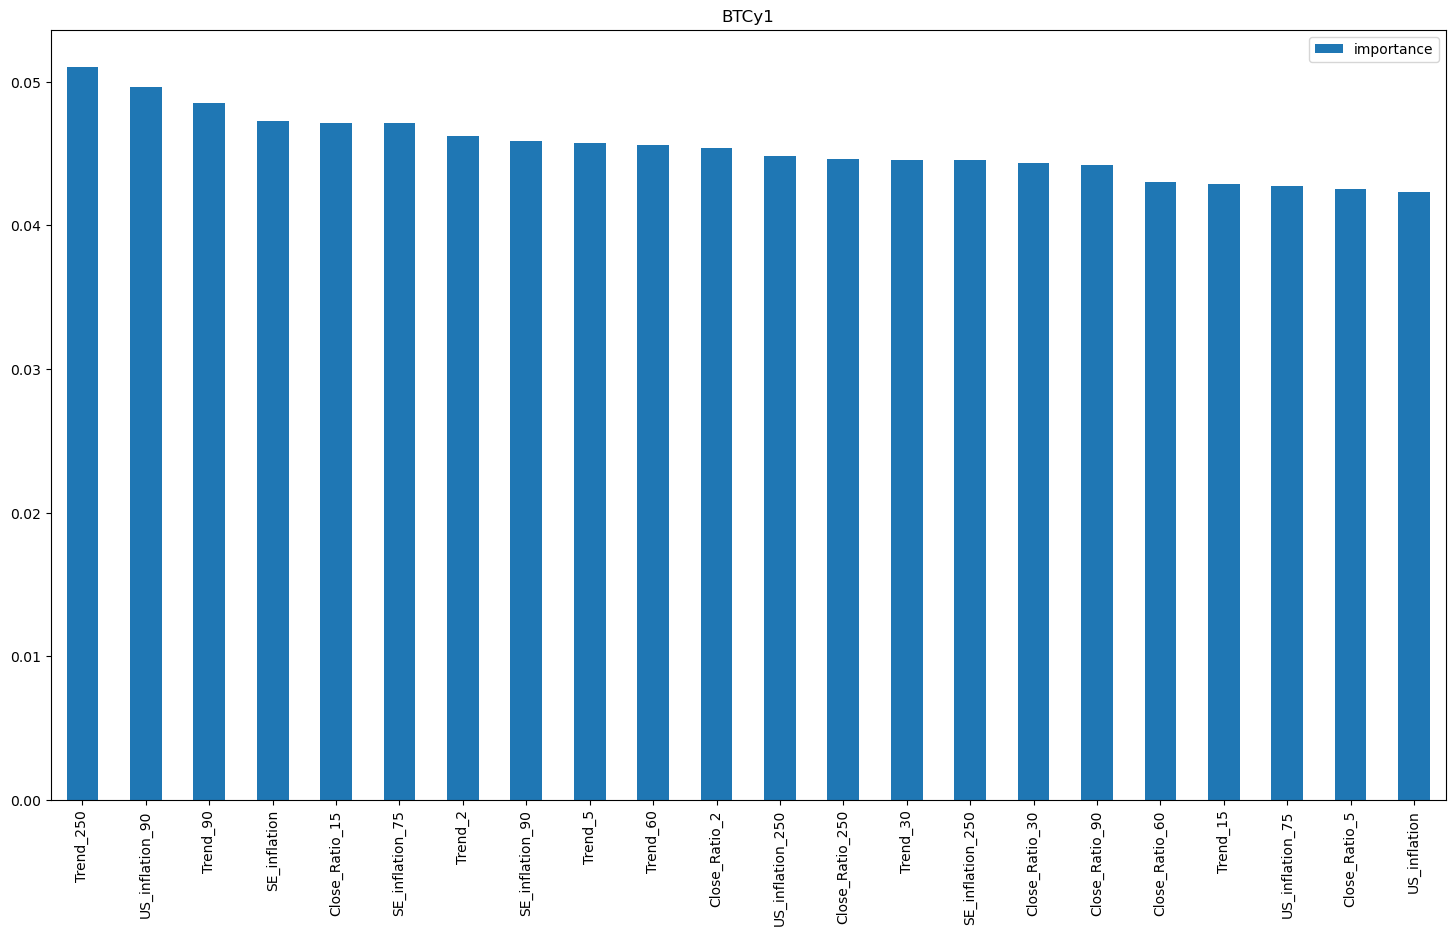

BTCy2
last date 2023-03-28
Fördelning av y2: 1 vs 0:
1.0    0.554991
0.0    0.445009
Name: y2, dtype: float64
y2   Predictions
1.0  0              1033
0.0  0               833
1.0  1               496
0.0  1               393
dtype: int64
Alg Precision:	0.5579
target upp: 1529, pred upp: 889, correct pred upp: 496, Precision: 0.5579
target ner: 1226, pred ner: 1866, correct pred ner: 833, Precision: 0.4464
Figure(1800x1000)


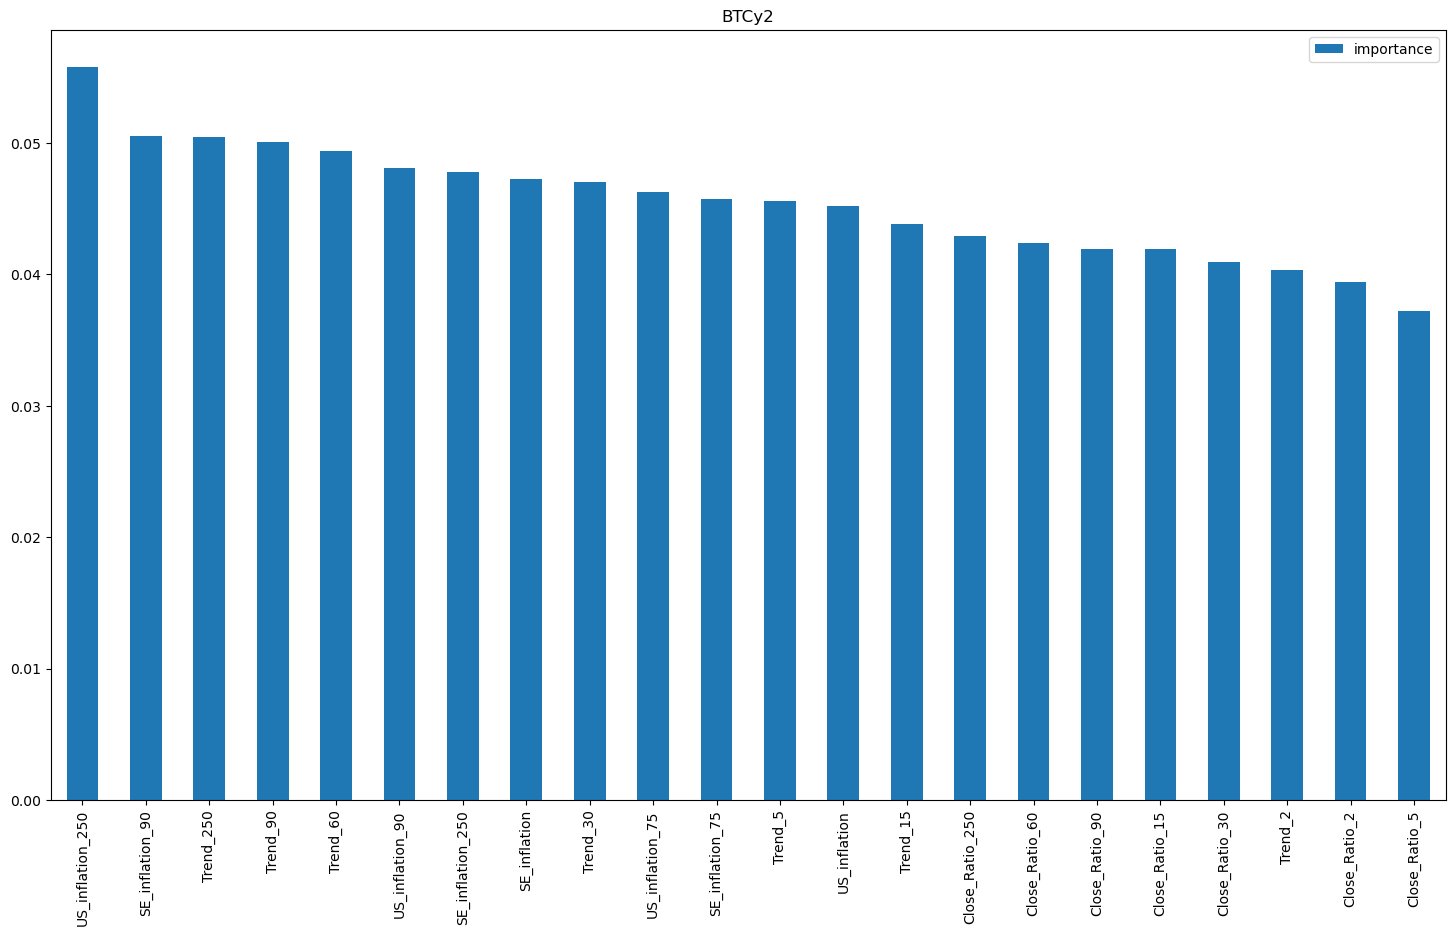

ETHy1
last date 2023-03-28
skipping until 1140 av 3115
Fördelning av y1: 1 vs 0:
1.0    0.51054
0.0    0.48946
Name: y1, dtype: float64
y1   Predictions
1.0  0              774
0.0  0              746
1.0  1              219
0.0  1              206
dtype: int64
Alg Precision:	0.5153
target upp: 993, pred upp: 425, correct pred upp: 219, Precision: 0.5153
target ner: 952, pred ner: 1520, correct pred ner: 746, Precision: 0.4908
Figure(1800x1000)


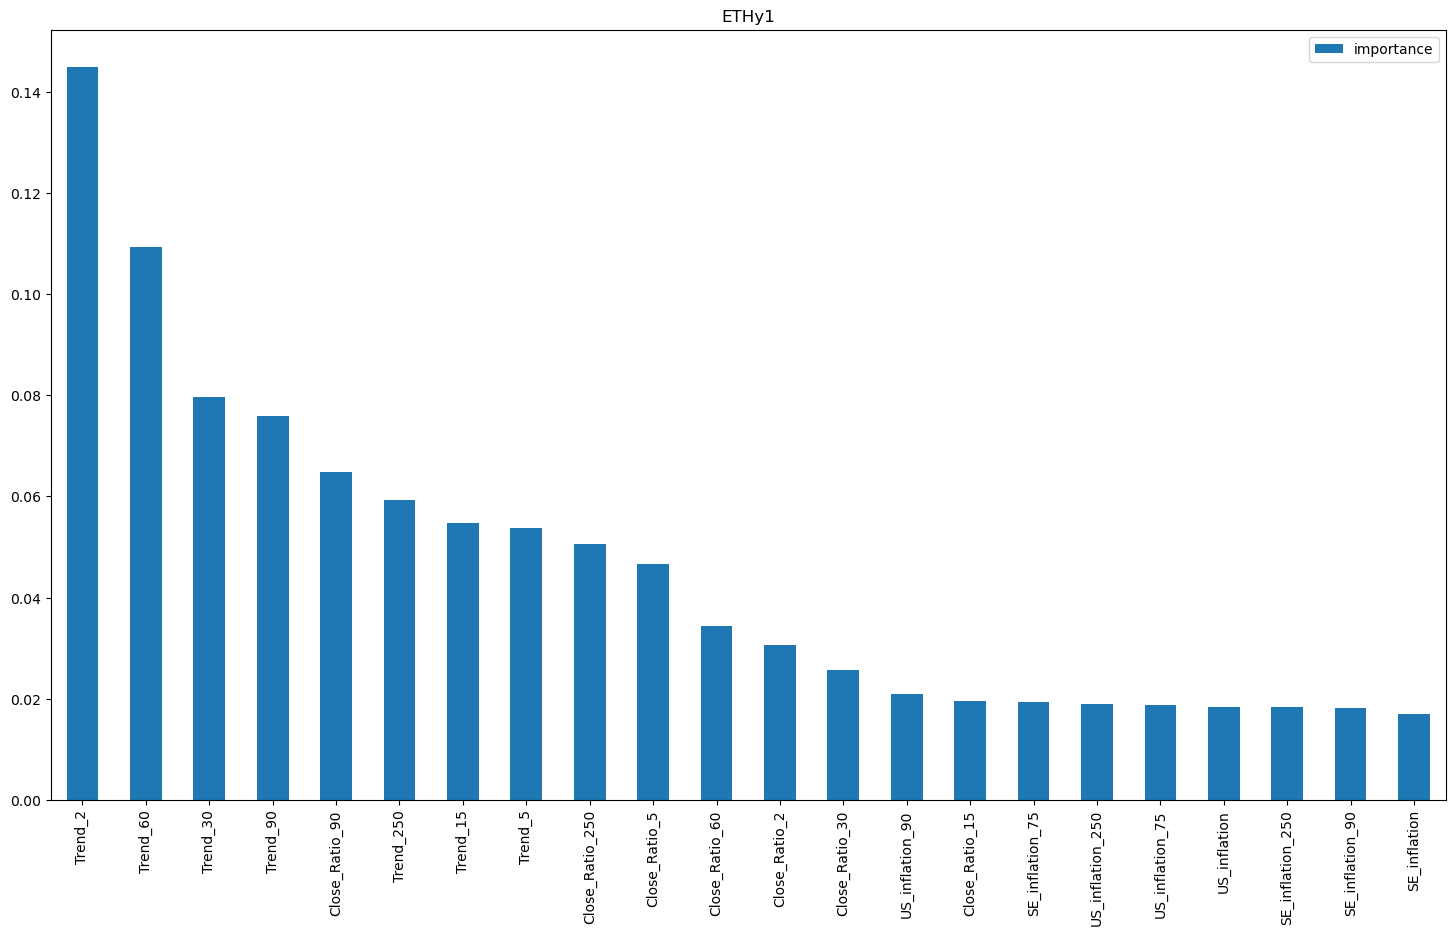

ETHy2
last date 2023-03-28
skipping until 1140 av 3115
Fördelning av y2: 1 vs 0:
1.0    0.514139
0.0    0.485861
Name: y2, dtype: float64
y2   Predictions
1.0  0              770
0.0  0              677
     1              268
1.0  1              230
dtype: int64
Alg Precision:	0.4618
target upp: 1000, pred upp: 498, correct pred upp: 230, Precision: 0.4618
target ner: 945, pred ner: 1447, correct pred ner: 677, Precision: 0.4679
Figure(1800x1000)


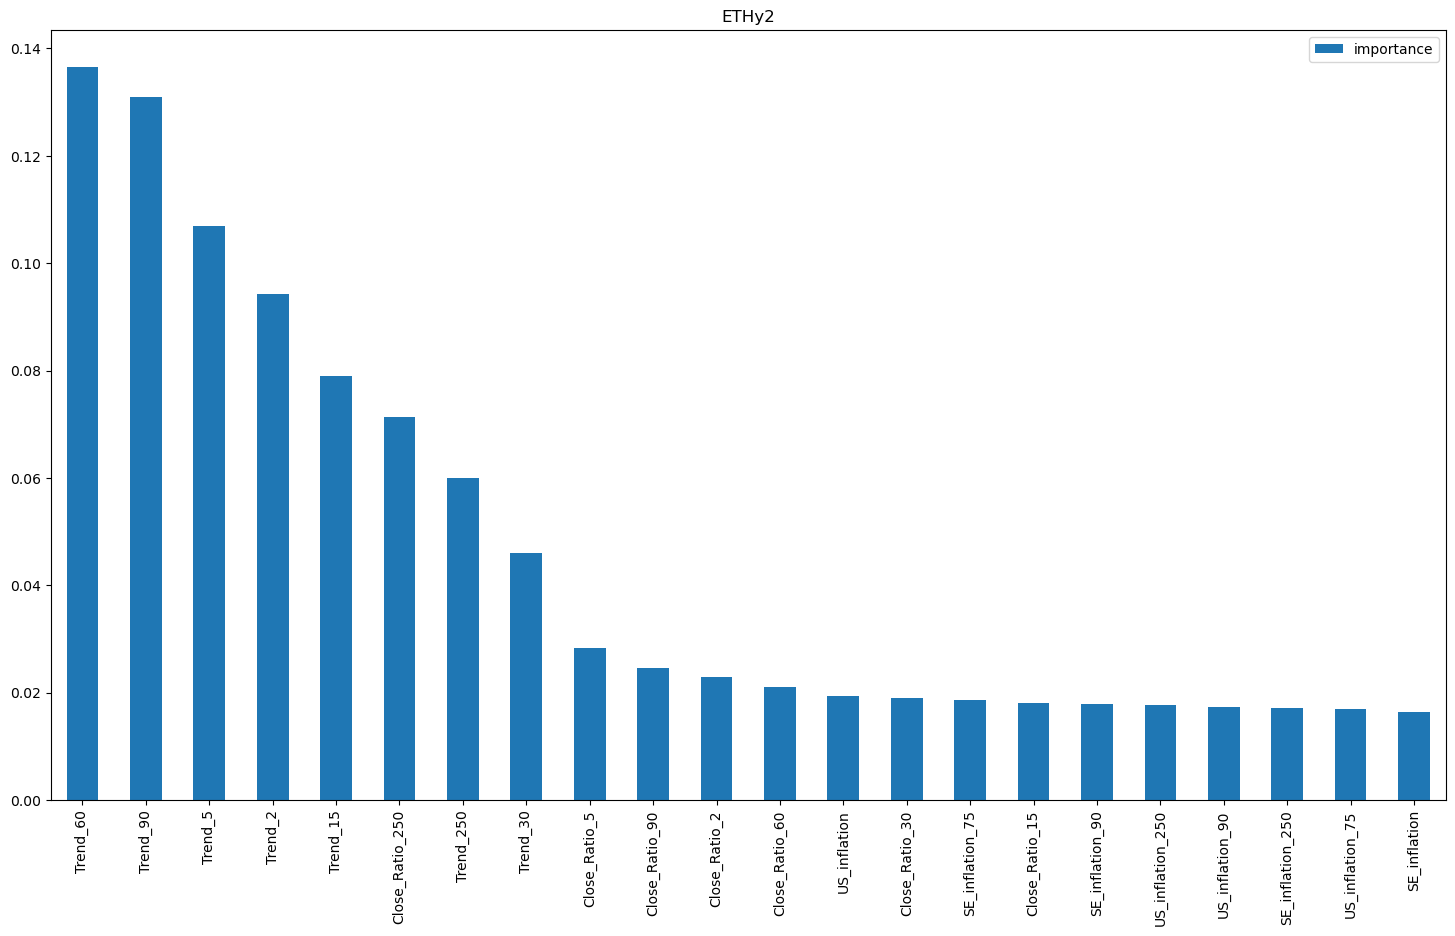

BCHy1
last date 2023-03-28
skipping until 1140 av 3115
Fördelning av y1: 1 vs 0:
0.0    0.513111
1.0    0.486889
Name: y1, dtype: float64
y1   Predictions
0.0  0              787
1.0  0              729
     1              218
0.0  1              211
dtype: int64
Alg Precision:	0.5082
target upp: 947, pred upp: 429, correct pred upp: 218, Precision: 0.5082
target ner: 998, pred ner: 1516, correct pred ner: 787, Precision: 0.5191
Figure(1800x1000)


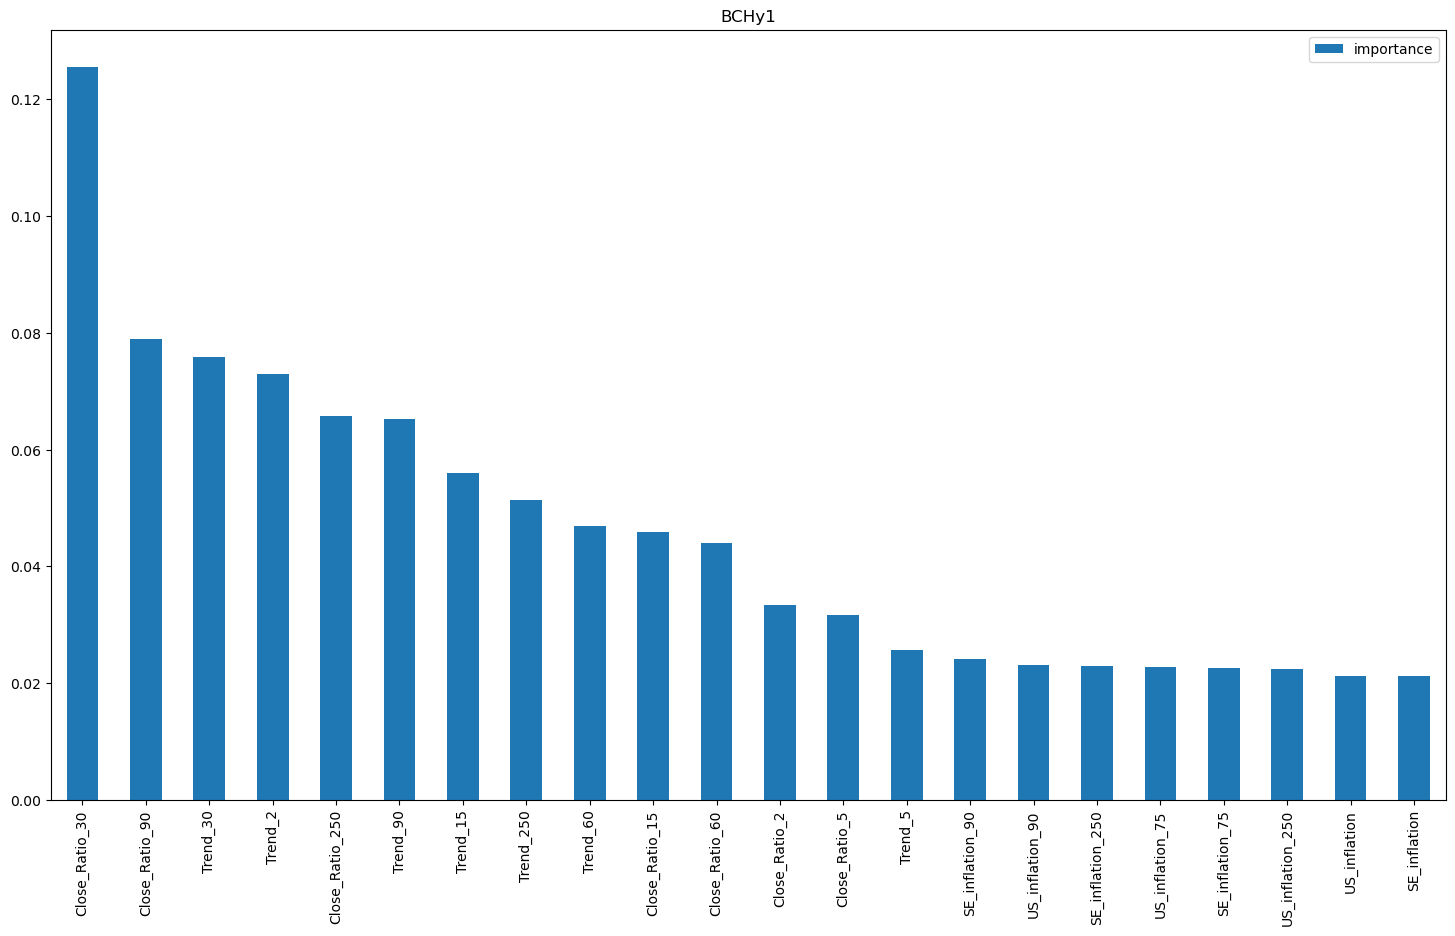

BCHy2
last date 2023-03-28
skipping until 1140 av 3115
Fördelning av y2: 1 vs 0:
0.0    0.52545
1.0    0.47455
Name: y2, dtype: float64
y2   Predictions
0.0  0              818
1.0  0              724
0.0  1              204
1.0  1              199
dtype: int64
Alg Precision:	0.4938
target upp: 923, pred upp: 403, correct pred upp: 199, Precision: 0.4938
target ner: 1022, pred ner: 1542, correct pred ner: 818, Precision: 0.5305
Figure(1800x1000)


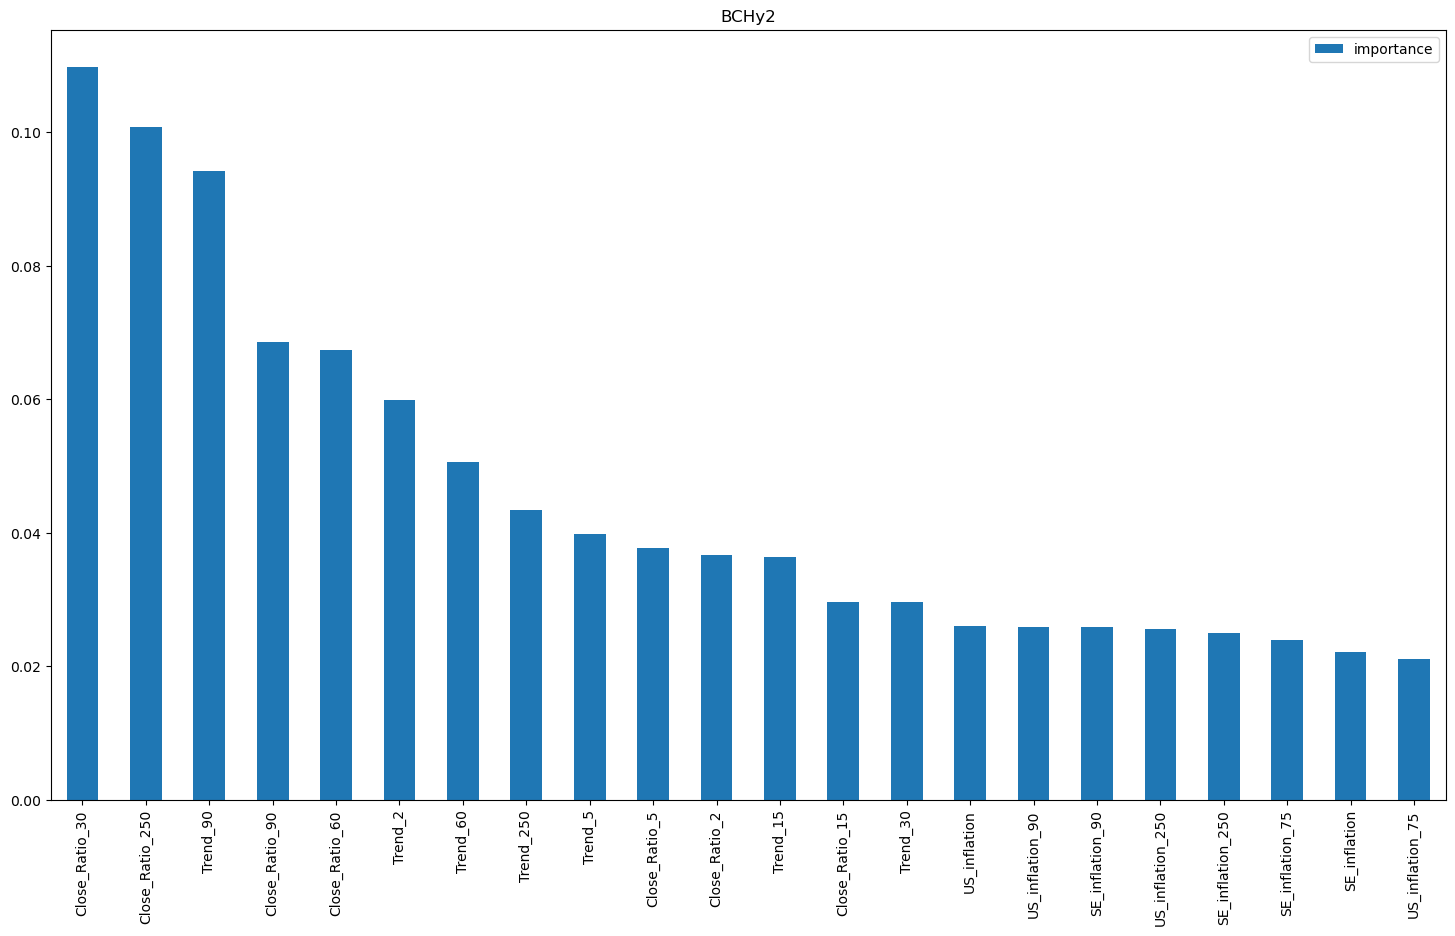

ZRXy1
last date 2023-03-28
skipping until 1140 av 3115
Fördelning av y1: 1 vs 0:
0.0    0.51054
1.0    0.48946
Name: y1, dtype: float64
y1   Predictions
0.0  0              832
1.0  0              780
     1              172
0.0  1              161
dtype: int64
Alg Precision:	0.5165
target upp: 952, pred upp: 333, correct pred upp: 172, Precision: 0.5165
target ner: 993, pred ner: 1612, correct pred ner: 832, Precision: 0.5161
Figure(1800x1000)


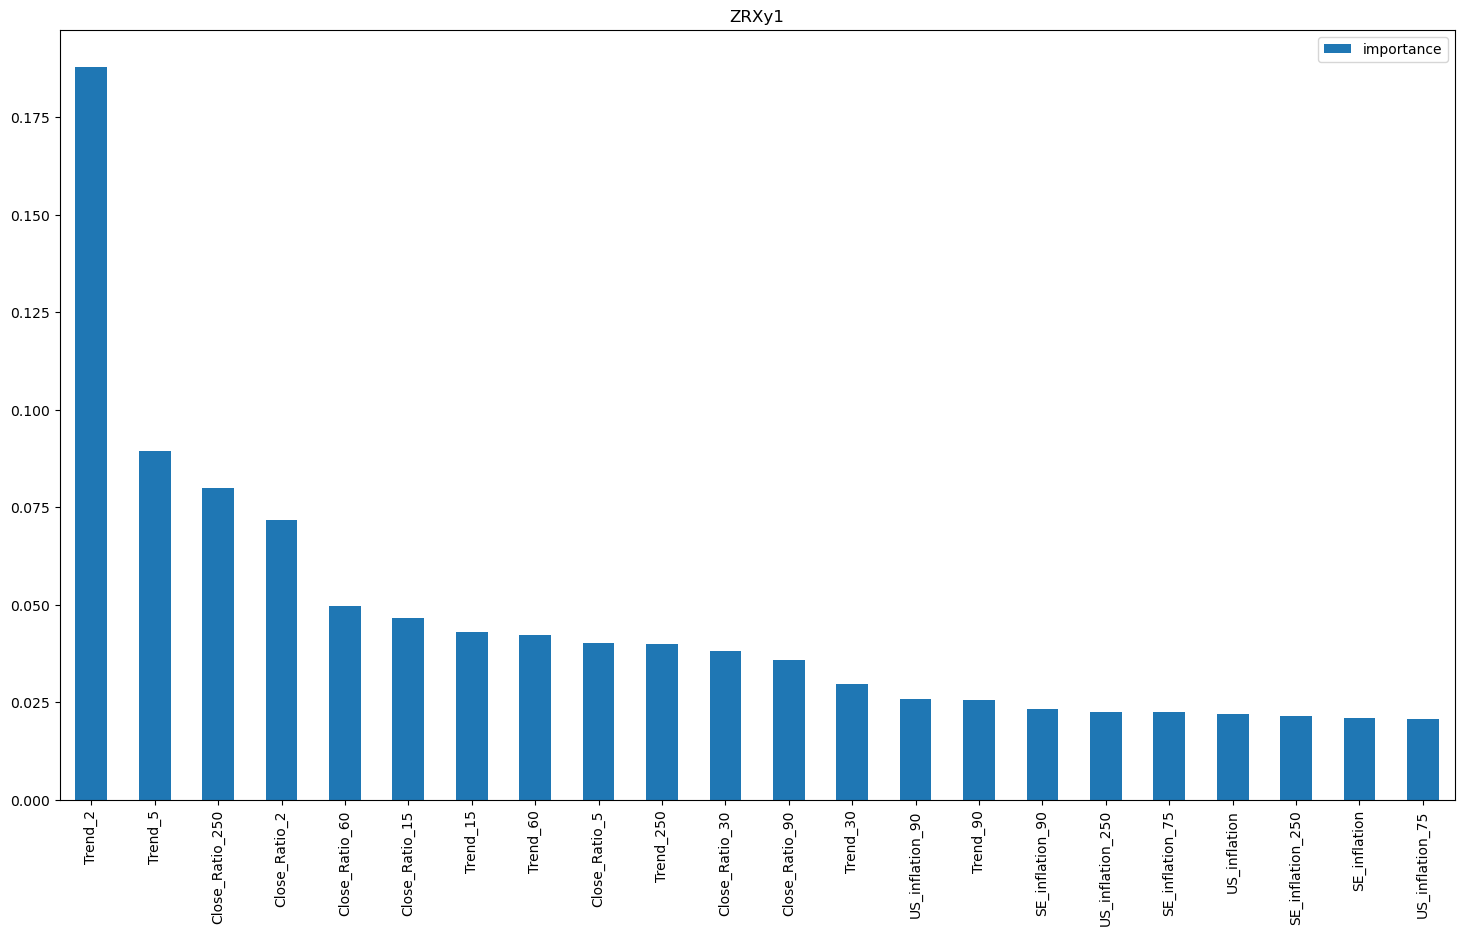

ZRXy2
last date 2023-03-28
skipping until 1140 av 3115
Fördelning av y2: 1 vs 0:
0.0    0.521337
1.0    0.478663
Name: y2, dtype: float64
y2   Predictions
0.0  0              815
1.0  0              755
0.0  1              199
1.0  1              176
dtype: int64
Alg Precision:	0.4693
target upp: 931, pred upp: 375, correct pred upp: 176, Precision: 0.4693
target ner: 1014, pred ner: 1570, correct pred ner: 815, Precision: 0.5191
Figure(1800x1000)


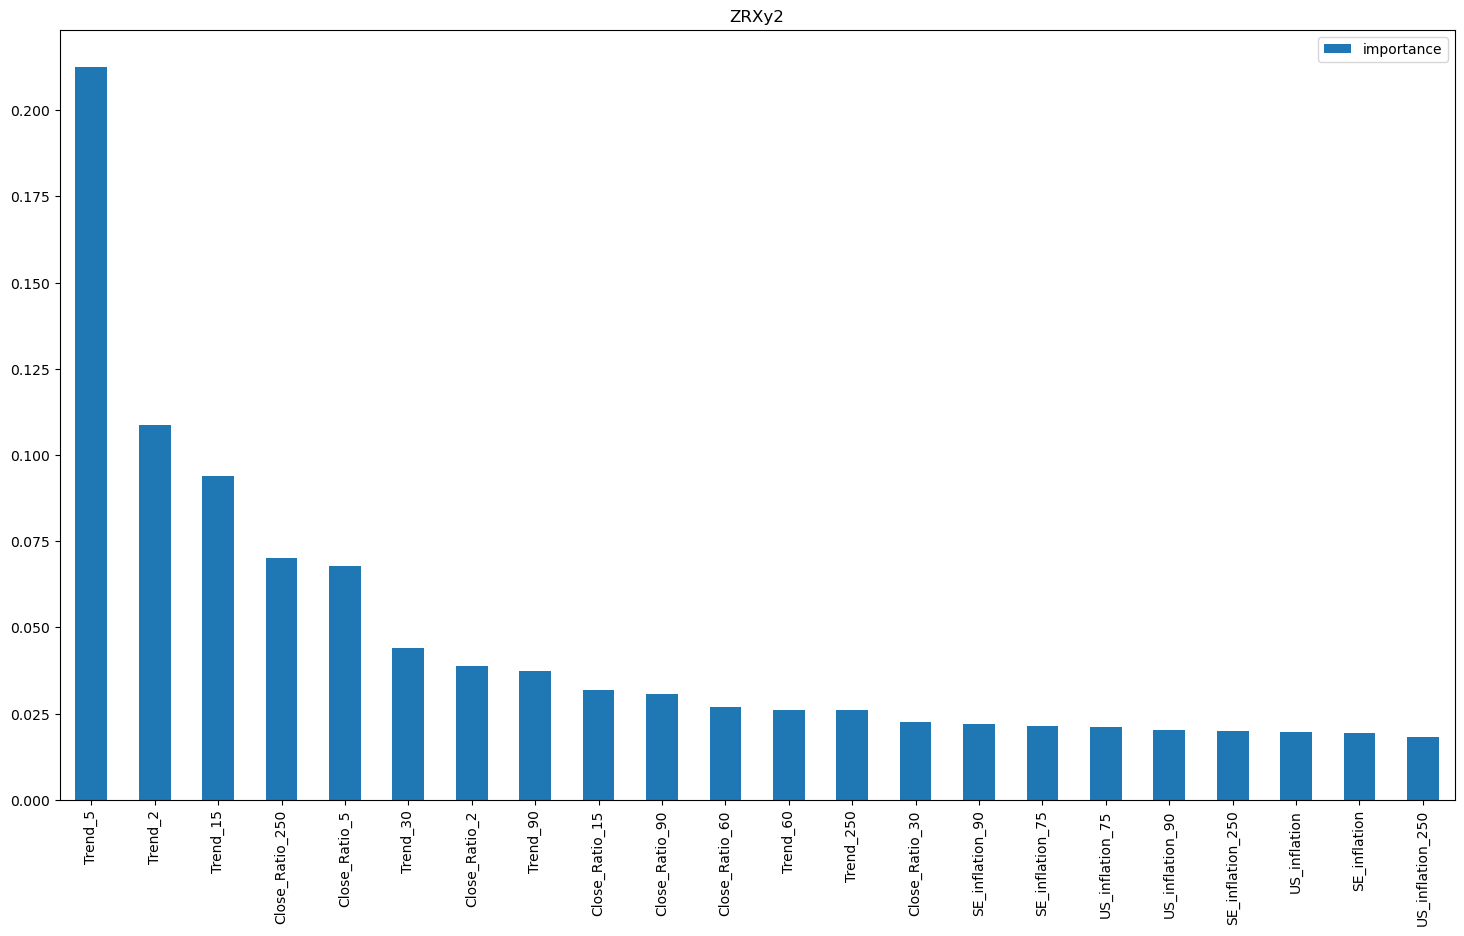

XRPy1
last date 2023-03-28
skipping until 1140 av 3115
Fördelning av y1: 1 vs 0:
0.0    0.510026
1.0    0.489974
Name: y1, dtype: float64
y1   Predictions
0.0  0              808
1.0  0              724
     1              229
0.0  1              184
dtype: int64
Alg Precision:	0.5545
target upp: 953, pred upp: 413, correct pred upp: 229, Precision: 0.5545
target ner: 992, pred ner: 1532, correct pred ner: 808, Precision: 0.5274
Figure(1800x1000)


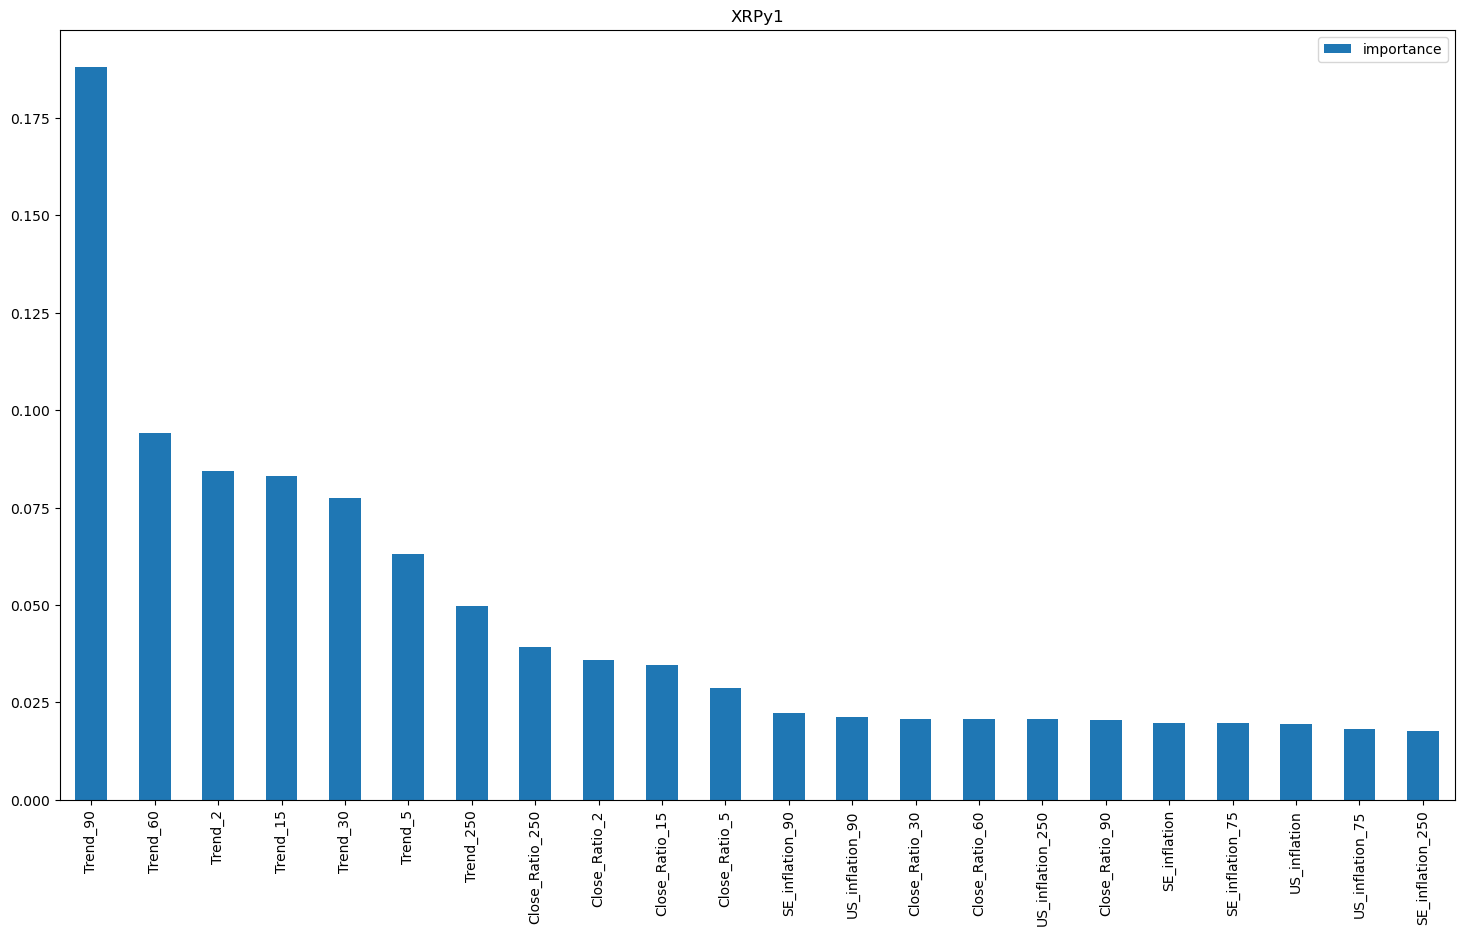

XRPy2
last date 2023-03-28
skipping until 1140 av 3115
Fördelning av y2: 1 vs 0:
0.0    0.527506
1.0    0.472494
Name: y2, dtype: float64
y2   Predictions
0.0  0              818
1.0  0              717
0.0  1              208
1.0  1              202
dtype: int64
Alg Precision:	0.4927
target upp: 919, pred upp: 410, correct pred upp: 202, Precision: 0.4927
target ner: 1026, pred ner: 1535, correct pred ner: 818, Precision: 0.5329
Figure(1800x1000)


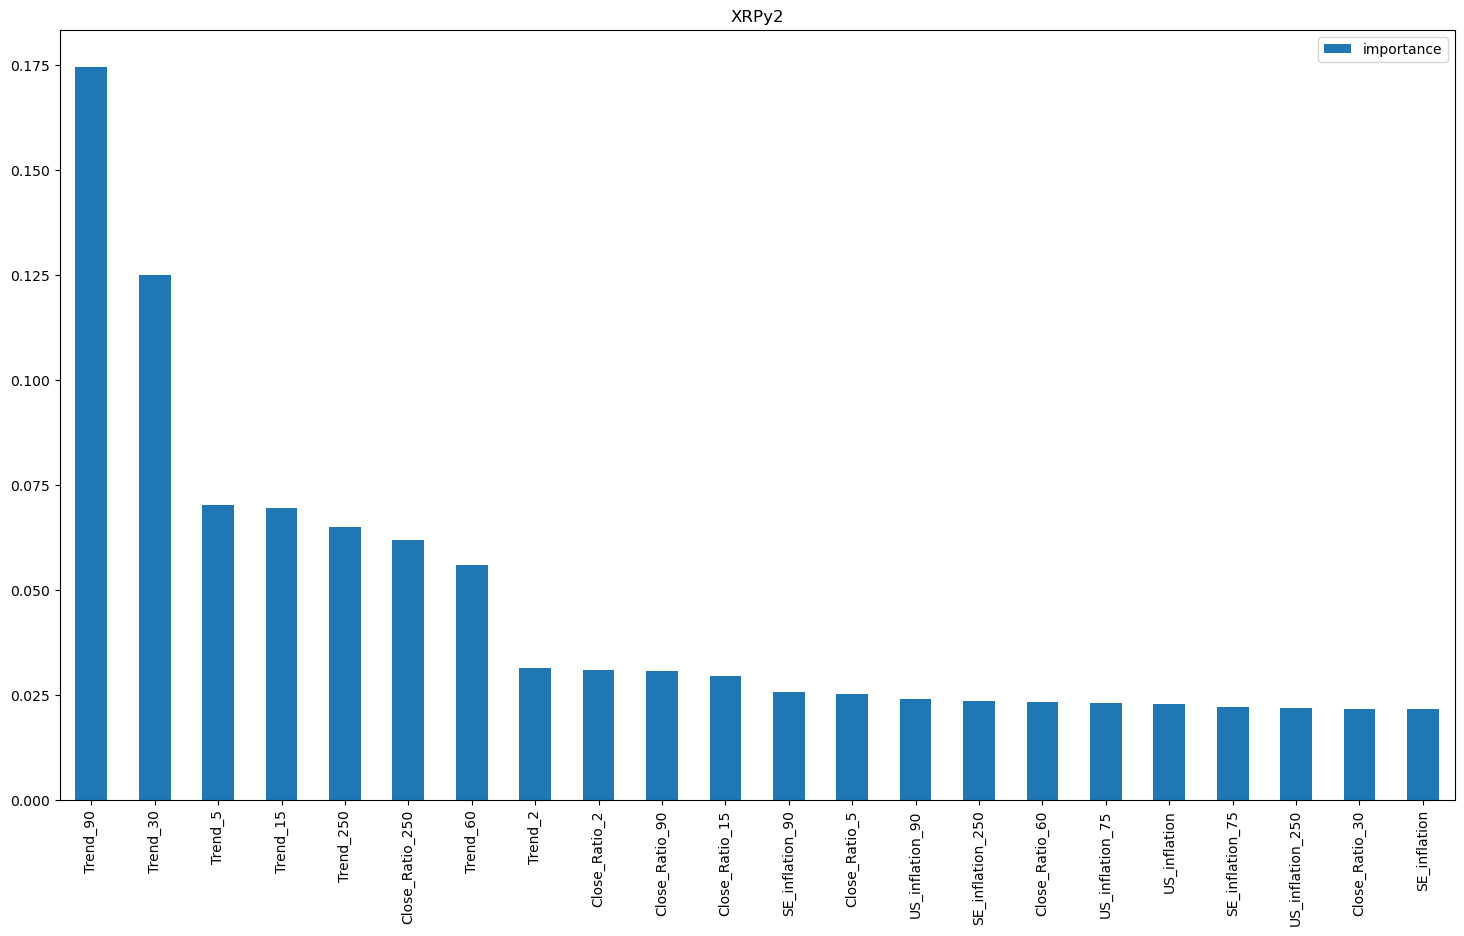

In [23]:
horizons=[2,5,15,30,60,90,250]
# precision_list, predictors = generate_all_xgbmodels(df_org, 
#                                                     tickers, 
#                                                     horizons=horizons, 
#                                                     save=True, 
#                                                     remove=['month','stoch_k','day_of_week','day_of_month'], 
#                                                     use_inflations=True)

precision_list, predictors = generate_all_models(df_org, 
                                                tickers, 
                                                horizons=horizons,
                                                model_type='xgb', 
                                                save=True, 
                                                remove=['month', 'stoch_k', 'day_of_week', 'day_of_month'], 
                                                ETH_BTC=False, 
                                                use_inflations=True)


'bad precision:'

,precision
BCHy2,0.493797
XRPy2,0.492683
ZRXy2,0.469333
ETHy2,0.461847


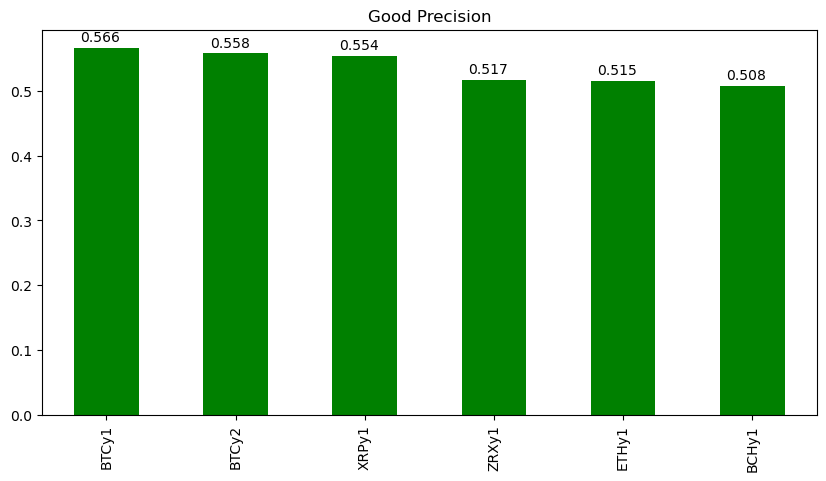

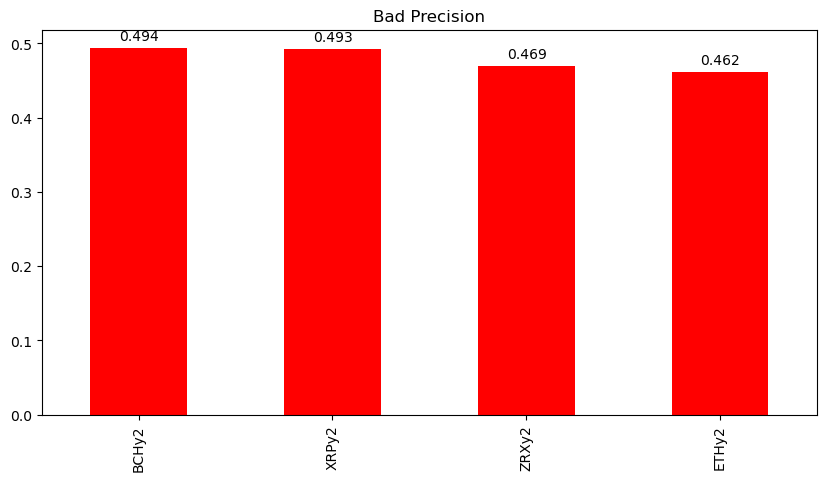

In [24]:

df_precision = pd.DataFrame(dict(precision_list), index=['precision']).T
df_precision.query('precision > 0.5').sort_values(by='precision',ascending=False).plot(kind='bar', figsize=(10,5), title = 'Good Precision', color='green', legend=False)
# plot values in bars
for i, v in enumerate(df_precision.query('precision > 0.5').sort_values(by='precision',ascending=False).values):
    plt.text(i-0.2, v+0.01, str(round(v[0],3)))
try:
    df_precision.query('precision <= 0.5').sort_values(by='precision',ascending=False).plot(kind='bar',  figsize=(10,5), title='Bad Precision',color='red', legend=False)
    # plot values in bars
    for i, v in enumerate(df_precision.query('precision <= 0.5').sort_values(by='precision',ascending=False).values):
        plt.text(i-0.1, v+0.01, str(round(v[0],3)))
except IndexError:
    print('No bad precision!')

display('bad precision:',df_precision.query('precision <= 0.5').sort_values(by='precision',ascending=False))
df_precision.to_csv('precision_lags_and_ratio_no_month_stochk_15_90.csv')
# df

# Bryt här. Det finns ett plotly-exempel sist

Kollar TimeSeriesSplit Cross Validation  
Jag gillar min egen backtest-variant bätte   
- Den har start vilket garanterar att första Train-datat inte är för litet  
- Den har step-size i stället för n_splits vilka ger samma index-värden om så önskas  
- Båda har gap 

In [25]:
horizons=[2,5,15,30,60,90,250]
df, predictors = create_predictors(df_org, tickers[0], 'y1', horizons=horizons)
# df, predictors = add_google_trends(df, df_trend, tickers[0], predictors)

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10,gap=1)
for train_index, test_index in tscv.split(df):
    print("TRAIN:", train_index[0], '-', train_index[-1], "\nTEST:", test_index[0], '-', test_index[-1])
    # X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    # y_train, y_test = df.iloc[train_index], df.iloc[test_index]


TRAIN: 0 - 283 
TEST: 285 - 567
TRAIN: 0 - 566 
TEST: 568 - 850
TRAIN: 0 - 849 
TEST: 851 - 1133
TRAIN: 0 - 1132 
TEST: 1134 - 1416
TRAIN: 0 - 1415 
TEST: 1417 - 1699
TRAIN: 0 - 1698 
TEST: 1700 - 1982
TRAIN: 0 - 1981 
TEST: 1983 - 2265
TRAIN: 0 - 2264 
TEST: 2266 - 2548
TRAIN: 0 - 2547 
TEST: 2549 - 2831
TRAIN: 0 - 2830 
TEST: 2832 - 3114


### Test plotly

In [26]:
df.columns

Index(['BTC-USD', 'ETH-USD', 'BCH-USD', 'ZRX-USD', 'XRP-USD', 'stoch_k', 'Tomorrow', 'After_tomorrow', 'y1', 'y2', 'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_15',
       'Trend_15', 'Close_Ratio_30', 'Trend_30', 'Close_Ratio_60', 'Trend_60', 'Close_Ratio_90', 'Trend_90', 'Close_Ratio_250', 'Trend_250', 'day_of_month', 'day_of_week', 'month'],
      dtype='object')

In [27]:
df[['BTC-USD', 'ETH-USD', 'BCH-USD', 'ZRX-USD', 'XRP-USD','Tomorrow','After_tomorrow', 'Trend_2', 'Trend_5', 'Close_Ratio_2']]

,BTC-USD,ETH-USD,BCH-USD,ZRX-USD,XRP-USD,Tomorrow,After_tomorrow,Trend_2,Trend_5,Close_Ratio_2
Date,,,,,,,,,,
2014-09-17,457.334015,NaN,NaN,NaN,NaN,424.440002,394.795990,NaN,NaN,1.000000
2014-09-18,424.440002,NaN,NaN,NaN,NaN,394.795990,408.903992,424.440002,424.440002,0.962696
2014-09-19,394.795990,NaN,NaN,NaN,NaN,408.903992,398.821014,409.617996,409.617996,0.963815
2014-09-20,408.903992,NaN,NaN,NaN,NaN,398.821014,402.152008,401.849991,409.379995,1.017554
2014-09-21,398.821014,NaN,NaN,NaN,NaN,402.152008,435.790985,403.862503,406.740250,0.987517
...,...,...,...,...,...,...,...,...,...,...
2023-03-24,27493.285156,1752.044800,123.892990,0.229557,0.425902,27494.707031,27994.330078,27913.628906,27815.549609,0.984941
2023-03-25,27494.707031,1743.764771,125.152679,0.224970,0.444716,27994.330078,27139.888672,27493.996094,27761.043750,1.000026
2023-03-26,27994.330078,1775.676758,124.873459,0.229373,0.448817,27139.888672,26939.019531,27744.518555,27724.746484,1.009004


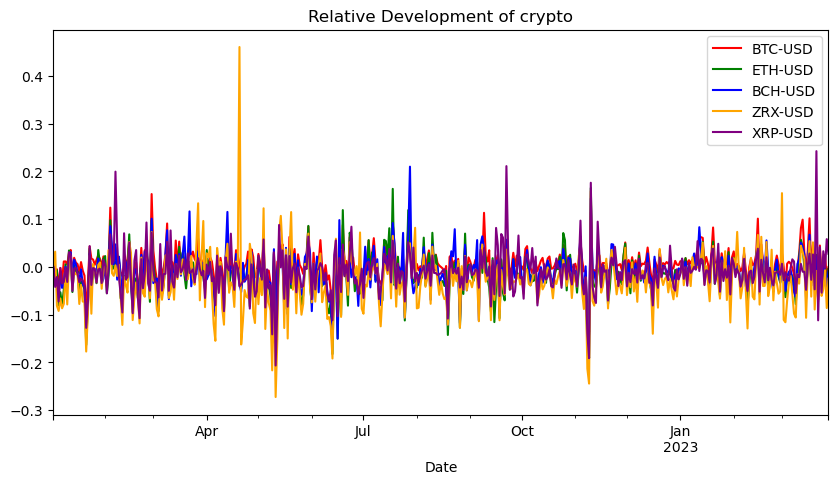

,BTC-USD,ETH-USD,BCH-USD,ZRX-USD,XRP-USD
Date,,,,,
2023-03-24,-0.022507,-0.051314,-0.045790,-0.060764,-0.053949
2023-03-25,0.007215,-0.020607,0.002571,-0.046586,0.032819
2023-03-26,0.025335,0.002419,-0.009828,-0.007032,-0.002134
2023-03-27,-0.023359,-0.049793,-0.044477,-0.086149,0.058103
2023-03-28,-0.000238,-0.004376,-0.009129,-0.024546,0.027539


In [30]:
# compute relative development
def rel_dev(df_ticker_):
    df_ticker = df_ticker_.copy()
    df_ticker = df_ticker/df_ticker.shift(1)-1
    df_ticker = df_ticker.dropna()
    just = df_ticker.head(1).values[0]
    df_ticker -= just
    return df_ticker

BTC = df[['BTC-USD']].query('index >= "2022-01-01"'); ETH = df[['ETH-USD']].query('index >= "2022-01-01"'); BCH = df[['BCH-USD']].query('index >= "2022-01-01"'); ZRX = df[['ZRX-USD']].query('index >= "2022-01-01"'); XRP = df[['XRP-USD']].query('index >= "2022-01-01"')

BTC = rel_dev(BTC)
ETH = rel_dev(ETH)
BCH = rel_dev(BCH)
ZRX = rel_dev(ZRX)
XRP = rel_dev(XRP)
# share x-axis

comb = pd.concat([BTC,ETH,BCH,ZRX,XRP],axis=1,)
# plot comb
comb.plot(figsize=(10,5), title='Relative Development of crypto', color=['red','green','blue','orange','purple'])
# share the same x-axis
plt.show()
display(comb.tail())

In [29]:
import plotly.graph_objects as go
import pandas as pd

# Assuming 'comb' is a DataFrame with the index as the x-axis values
x_values = comb.index

# Create a plotly line chart
fig = go.Figure()

# Add lines for each cryptocurrency with custom colors
fig.add_trace(go.Scatter(
    x=x_values, y=comb['BTC-USD'], mode='lines', name='BTC-USD', line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(
    x=x_values, y=comb['ETH-USD'], mode='lines', name='ETH-USD', line=dict(color='green', width=2)))
fig.add_trace(go.Scatter(
    x=x_values, y=comb['BCH-USD'], mode='lines', name='BCH-USD', line=dict(color='red', width=2)))
fig.add_trace(go.Scatter(
    x=x_values, y=comb['ZRX-USD'], mode='lines', name='ZRX-USD', line=dict(color='orange', width=2)))
fig.add_trace(go.Scatter(
    x=x_values, y=comb['XRP-USD'], mode='lines', name='XRP-USD', line=dict(color='purple', width=2)))

# Set the chart title
fig.update_layout(title='Price')

# Set the chart size
fig.update_layout(height=800, width=1000)

fig.show()
